(parameters_recovery)=
# Parameters recovery, prior predictive and posterior predictive sampling

In [1]:
%%capture
import sys
if 'google.colab' in sys.modules:
    ! pip install pyhgf

In [2]:
from numpy import loadtxt
import numpy as np
from pyhgf.distribution import hgf_logp, HGFDistribution
from pyhgf import load_data
import jax.numpy as jnp
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

np.random.seed(123)

In this tutorial, we are going to demonstrate some forms of parameters recovery, prior predictive and posterior predictive sampling that can be a way to assess the strength of the model fitting.

## Continuous HGF
### Simulate a dataset

In [3]:
n_data = 6
dataset = []
for participant in range(n_data):
    input_data = []
    kappa_1 = 1.0
    omega_1 = -10.0
    omega_2 = -10.0
    mu_1 = 0.0
    mu_2 = 0.0
    pi_1 = 1e4
    pi_2 = 1e1
    
    # two-level hierarchical gaussian random walk
    for i in range(1000):
        
        # x2
        pi_2 = np.exp(omega_2)
        mu_2 = np.random.normal(mu_2, pi_2**.5)

        # x1
        pi_1 = np.exp(kappa_1 * mu_2 + omega_1)
        mu_1 = np.random.normal(mu_1, pi_1**.5)
        
        # input node
        u = np.random.normal(mu_1, 1e-4**.5)
        input_data.append(u)

    dataset.append(np.array(input_data))

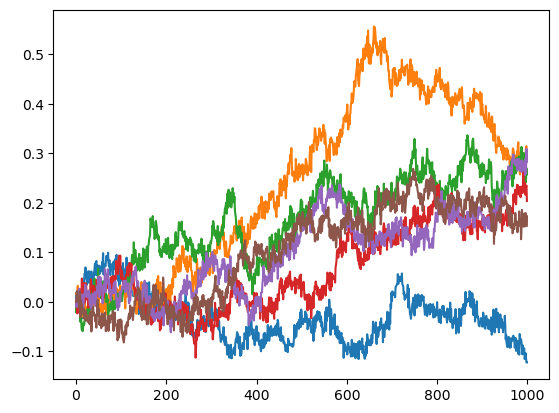

In [4]:
for rw in dataset:
    plt.plot(rw)

## Embedding a serie of HGFs in a graphical model

Here, we are goingin to estimate the parameter $omega_{1}$ from the time series created by the hierarchical random walks. All the time series were generated using $omega_{1} = -10.0$ and we want to see how the Bayesian inference can retrieve these values.

In [5]:
hgf_logp_op = HGFDistribution(
    n_levels=2,
    model_type="continuous",
    input_data=dataset,
)

In [6]:
with pm.Model() as model:
    
    # Priors
    # ------
    tonic_volatility_1 = pm.Normal("omega_1", mu=0.0, sigma=2.0, shape=n_data)

    # The multi-HGF distribution
    # --------------------------
    pm.Potential("hgf_loglike", hgf_logp_op(tonic_volatility_1=tonic_volatility_1, tonic_volatility_2=-10.0))

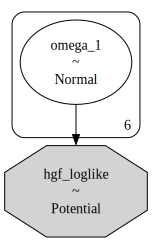

In [7]:
pm.model_to_graphviz(model)

In [8]:
with model:
    idata = pm.sample(chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [omega_1]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 40 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


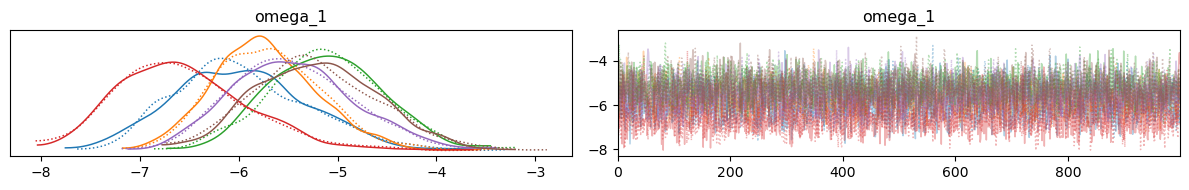

In [9]:
az.plot_trace(idata);
plt.tight_layout()

In [10]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
omega_1[0],-5.974,0.672,-7.161,-4.726,0.014,0.010,2609.0,1496.0,1.00
omega_1[1],-5.716,0.533,-6.695,-4.731,0.016,0.011,1245.0,1350.0,1.01
omega_1[2],-5.114,0.566,-6.153,-4.043,0.012,0.009,2213.0,1609.0,1.00
omega_1[3],-6.562,0.666,-7.708,-5.314,0.015,0.010,2230.0,1310.0,1.00
omega_1[4],-5.451,0.611,-6.538,-4.311,0.013,0.009,2369.0,1473.0,1.00
omega_1[5],-5.215,0.618,-6.268,-3.969,0.014,0.010,1995.0,1505.0,1.00


# System configuration

In [11]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib

Last updated: Mon Oct 02 2023

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.14.0

pyhgf : 0.0.9
jax   : 0.4.14
jaxlib: 0.4.14

jax       : 0.4.14
sys       : 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:39:03) 
[GCC 11.3.0]
matplotlib: 3.7.1
pymc      : 5.5.0
arviz     : 0.16.1
numpy     : 1.22.0

Watermark: 2.4.3

